# Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 

## Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv("bank-full.csv", sep=";")
features = ["age", "job", "marital", "education", "balance", "housing", "contact",
            "day", "month", "duration", "campaign", "pdays", "previous", "poutcome"]
target = "y"
df = df[features + [target]]
df["y"] = df["y"].replace({"yes": 1, "no": 0}).astype(int)

numeric = []
categorical = []
for f in features:
    if df.dtypes[f] == "object":
        categorical.append(f)
    else:
        numeric.append(f)

/tmp/ipykernel_12487/905633868.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["y"] = df["y"].replace({"yes": 1, "no": 0}).astype(int)


In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [4]:
auc_scores = []
for f in numeric:
    auc = roc_auc_score(y_train, df_train[f])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[f])
    auc_scores.append(auc)

print(f"{numeric[np.argmax(auc_scores)]} has the highest AUC")

duration has the highest AUC


## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [5]:
train_dict = df_train[features].to_dict(orient='records')
val_dict = df_val[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

clf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
clf.fit(X_train, y_train)
auc = roc_auc_score(y_val, clf.predict(X_val))

print(f"AUC of this model on the validation dataset is {round(auc, 2)}")

AUC of this model on the validation dataset is 0.66


## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

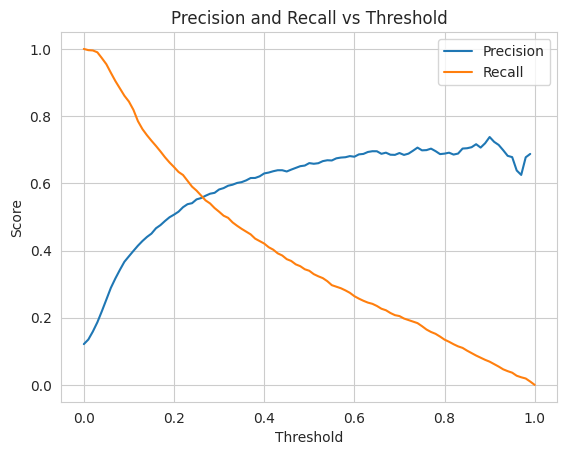

Precision and recall curves intersect at threshold=0.26


In [6]:
thresholds = np.linspace(0.0, 1.0, 101)
y_prob = clf.predict_proba(X_val)[:, 1]
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred = np.where(y_prob > threshold, 1, 0)
    precision = precision_score(y_val, y_pred, zero_division=np.nan)
    recall = recall_score(y_val, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)

precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
sns.lineplot(x=thresholds, y=precision_scores, label="Precision")
sns.lineplot(x=thresholds, y=recall_scores, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.show()
intersect = thresholds[np.argmin(np.abs(precision_scores[:-1] - recall_scores[:-1]))]
print(f"Precision and recall curves intersect at threshold={intersect}")

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [7]:
thresholds = np.linspace(0.0, 1.0, 101)
y_prob = clf.predict_proba(X_val)[:, 1]
f1_scores = []

for threshold in thresholds:
    y_pred = np.where(y_prob > threshold, 1, 0)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)
    
print(f"F1 is maximal at threshold={thresholds[np.argmax(f1_scores)]}")

F1 is maximal at threshold=0.22


## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
X = df[features]
y = df[target]
auc_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx].to_dict(orient="records"), X.iloc[val_idx].to_dict(orient="records")
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(X_train)
    X_val = dv.transform(X_val)
    clf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

print(f"Standard deviation of the scores across different folds is {np.std(auc_scores):.5f}")

Standard deviation of the scores across different folds is 0.00522


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [9]:
alphas = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)
X = df[features]
y = df[target]
auc_scores = [[] for _ in range(len(alphas))]

for i, C in enumerate(alphas):
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx].to_dict(orient="records"), X.iloc[val_idx].to_dict(orient="records")
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(X_train)
        X_val = dv.transform(X_val)
        clf = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        auc_scores[i].append(auc)
        
avg_auc = np.mean(auc_scores, axis=1)        
print(f"C={alphas[np.argmax(avg_auc)]} leads to the best mean score")

C=1 leads to the best mean score


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw04
* If your answer doesn't match options exactly, select the closest one